In [15]:
# Exact Diagonalization
import numpy as np
from numpy import kron
from scipy.linalg import eigh

# Pauli matrices
I = np.eye(2)
sx = np.array([[0, 1], [1, 0]])
sz = np.array([[1, 0], [0, -1]])

def op_on_site(op, site, N):
    """Place single-qubit operator on site"""
    ops = [I]*N
    ops[site] = op
    result = ops[0]
    for o in ops[1:]:
        result = kron(result, o)
    return result

def two_site_op(op1, i, op2, j, N):
    ops = [I]*N
    ops[i] = op1
    ops[j] = op2
    result = ops[0]
    for o in ops[1:]:
        result = kron(result, o)
    return result

def tfim_hamiltonian(h, N=4):
    H = np.zeros((2**N, 2**N))

    # ZZ interaction
    for i in range(N-1):
        H -= two_site_op(sz, i, sz, i+1, N)

    # Transverse field
    for i in range(N):
        H -= h * op_on_site(sx, i, N)

    return H

In [16]:
# Computing Observables
hs = np.linspace(0, 2, 50)

E0, gap, Mz = [], [], []

N = 4

for h in hs:
    H = tfim_hamiltonian(h, N)
    evals, evecs = eigh(H)

    E0.append(evals[0])
    gap.append(evals[1] - evals[0])

    psi0 = evecs[:, 0]

    mz = 0
    for i in range(N):
        mz += psi0.conj().T @ op_on_site(sz, i, N) @ psi0
    Mz.append(np.real(mz) / N)

In [17]:
print("h    Ground Energy    Gap     Magnetization")
for i in range(0, len(hs), 10):
    print(f"{hs[i]:.2f}  {E0[i]:.4f}        {gap[i]:.4f}    {Mz[i]:.4f}")

h    Ground Energy    Gap     Magnetization
0.00  -3.0000        0.0000    1.0000
0.41  -3.2759        0.0464    -0.0000
0.82  -4.1926        0.4220    -0.0000
1.22  -5.5167        1.0706    -0.0000
1.63  -6.9931        1.8130    -0.0000


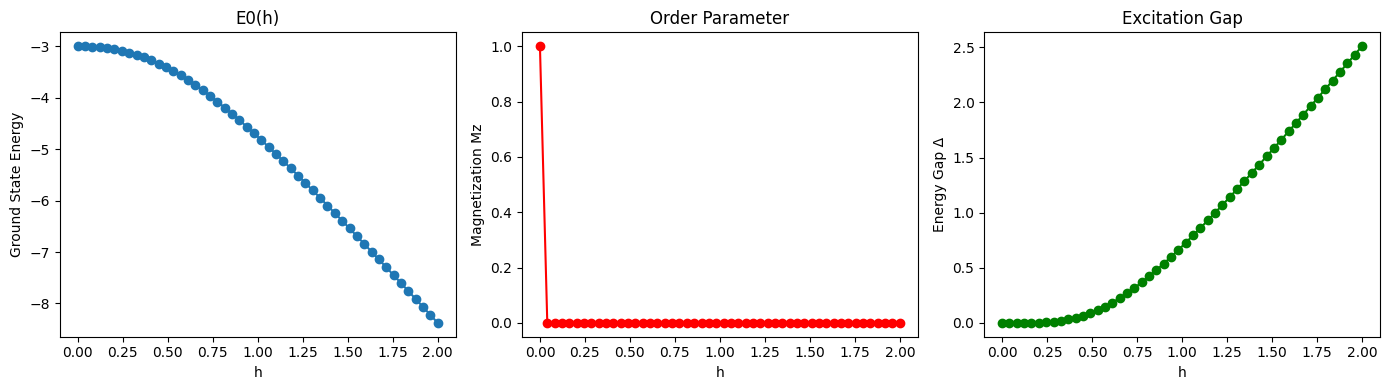

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))

# Ground state energy
plt.subplot(1,3,1)
plt.plot(hs, E0, 'o-')
plt.xlabel("h")
plt.ylabel("Ground State Energy")
plt.title("E0(h)")

# Magnetization
plt.subplot(1,3,2)
plt.plot(hs, Mz, 'o-', color='red')
plt.xlabel("h")
plt.ylabel("Magnetization Mz")
plt.title("Order Parameter")

# Energy gap
plt.subplot(1,3,3)
plt.plot(hs, gap, 'o-', color='green')
plt.xlabel("h")
plt.ylabel("Energy Gap Δ")
plt.title("Excitation Gap")

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector

In [20]:
# Hamiltonian Construction
def tfim_hamiltonian_qiskit(h, N=4):
    paulis = []
    coeffs = []

    # ZZ terms
    for i in range(N-1):
        z = ['I'] * N
        z[i] = 'Z'
        z[i+1] = 'Z'
        paulis.append(''.join(z))
        coeffs.append(-1.0)

    # X field terms
    for i in range(N):
        x = ['I'] * N
        x[i] = 'X'
        paulis.append(''.join(x))
        coeffs.append(-h)

    return SparsePauliOp(paulis, coeffs)

In [21]:
# Ansatz Circuit
def tfim_ansatz(N=4, layers=2):
    qc = QuantumCircuit(N)

    for l in range(layers):
        # Use ParameterVector to create multiple parameters for each layer
        theta_z_params = ParameterVector(f"θz_{l}", N-1)
        theta_x_params = ParameterVector(f"θx_{l}", N)

        # ZZ entangling layer
        for i in range(N-1):
            qc.cx(i, i+1)
            qc.rz(theta_z_params[i], i+1)
            qc.cx(i, i+1)

        # Transverse field layer
        for i in range(N):
            qc.rx(theta_x_params[i], i)

    return qc

In [22]:
# Running VQE for One Field Value
def run_vqe(h):
    H = tfim_hamiltonian_qiskit(h)
    ansatz = tfim_ansatz()

    optimizer = COBYLA(maxiter=300)
    estimator = Estimator()

    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(H)

    return np.real(result.eigenvalue)

In [23]:
# Parameter Sweep
hs = np.linspace(0, 2, 15)
E_vqe = []

for h in hs:
    energy = run_vqe(h)
    E_vqe.append(energy)
    print(f"h = {h:.2f}, VQE Energy = {energy:.4f}")

h = 0.00, VQE Energy = -3.0000
h = 0.14, VQE Energy = -3.0215
h = 0.29, VQE Energy = -3.0813
h = 0.43, VQE Energy = -3.2460
h = 0.57, VQE Energy = -3.4012
h = 0.71, VQE Energy = -3.6143
h = 0.86, VQE Energy = -3.8213
h = 1.00, VQE Energy = -4.0349
h = 1.14, VQE Energy = -4.2845
h = 1.29, VQE Energy = -4.5155
h = 1.43, VQE Energy = -4.8009
h = 1.57, VQE Energy = -4.9908
h = 1.71, VQE Energy = -5.2754
h = 1.86, VQE Energy = -5.5325
h = 2.00, VQE Energy = -5.7956


In [24]:
def run_vqe_full(h, N=4, layers=2):
    H = tfim_hamiltonian_qiskit(h, N)
    ansatz = tfim_ansatz(N, layers)

    optimizer = COBYLA(maxiter=300)
    estimator = Estimator()

    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(H)

    # FIXED LINE
    optimal_circuit = ansatz.assign_parameters(result.optimal_parameters)

    return float(np.real(result.eigenvalue)), optimal_circuit

In [25]:
energy, circuit = run_vqe_full(0.5)
print("Energy:", energy)
print(circuit)

Energy: -3.288308371152702
                             ┌────────────┐                                    »
q_0: ──■──────────────────■──┤ Rx(4.1053) ├────────────────────────────────────»
     ┌─┴─┐┌────────────┐┌─┴─┐└────────────┘                    ┌──────────────┐»
q_1: ┤ X ├┤ Rz(4.9474) ├┤ X ├──────■────────────────────────■──┤ Rx(-0.58953) ├»
     └───┘└────────────┘└───┘    ┌─┴─┐     ┌─────────────┐┌─┴─┐└──────────────┘»
q_2: ────────────────────────────┤ X ├─────┤ Rz(-2.5141) ├┤ X ├───────■────────»
                                 └───┘     └─────────────┘└───┘     ┌─┴─┐      »
q_3: ───────────────────────────────────────────────────────────────┤ X ├──────»
                                                                    └───┘      »
«                                              ┌─────────────┐              »
«q_0: ──────■──────────────────────────■───────┤ Rx(-5.3152) ├──────────────»
«         ┌─┴─┐     ┌───────────┐    ┌─┴─┐     └─────────────┘              »
«q_1: ────

In [26]:
# Magnetization Measurement
from qiskit.primitives import StatevectorSampler as Sampler


def compute_magnetization(circuit, N=4, shots=5000):
    qc = circuit.copy()
    qc.measure_all()

    sampler = Sampler()
    job = sampler.run([qc], shots=shots)
    result = job.result()

    # THIS is the correct V2 access pattern
    counts = result[0].data.meas.get_counts()

    mz = 0.0
    for bitstring, count in counts.items():
        prob = count / shots
        z_vals = [1 if b == '0' else -1 for b in bitstring]
        mz += prob * sum(z_vals)

    return mz / N




In [27]:
energy, circuit = run_vqe_full(0.5)
mz = compute_magnetization(circuit)

print("Energy:", energy)
print("Mz:", mz)

Energy: -3.32828818120916
Mz: 0.9435


In [28]:
hs = np.linspace(0, 2, 12)

E_vqe = []
Mz_vqe = []

for h in hs:
    energy, circuit = run_vqe_full(h, layers=2)
    mz = compute_magnetization(circuit)

    E_vqe.append(energy)
    Mz_vqe.append(mz)

    print(f"h={h:.2f} | E0={energy:.4f} | Mz={mz:.4f}")

h=0.00 | E0=-3.0000 | Mz=-1.0000
h=0.18 | E0=-3.0383 | Mz=0.9915
h=0.36 | E0=-3.1349 | Mz=-0.9707
h=0.55 | E0=-3.3851 | Mz=-0.9373
h=0.73 | E0=-3.6220 | Mz=0.9087
h=0.91 | E0=-3.9045 | Mz=-0.8846
h=1.09 | E0=-4.1959 | Mz=-0.8619
h=1.27 | E0=-4.5186 | Mz=-0.8464
h=1.45 | E0=-4.7954 | Mz=-0.8215
h=1.64 | E0=-5.1465 | Mz=0.8120
h=1.82 | E0=-5.4648 | Mz=0.7996
h=2.00 | E0=-5.8525 | Mz=-0.7947


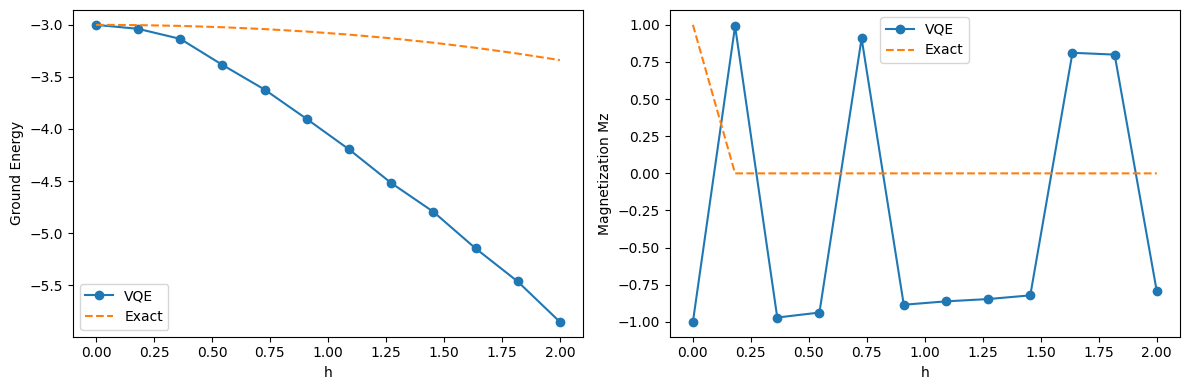

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hs, E_vqe, 'o-', label='VQE')
plt.plot(hs, E0[:len(hs)], '--', label='Exact')
plt.xlabel("h")
plt.ylabel("Ground Energy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hs, Mz_vqe, 'o-', label='VQE')
plt.plot(hs, Mz[:len(hs)], '--', label='Exact')
plt.xlabel("h")
plt.ylabel("Magnetization Mz")
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
depths = [1, 2, 3]
hs = [0.2, 0.6, 1.0, 1.4, 1.8]

In [31]:
results = {}

for layers in depths:
    E_list = []
    Mz_list = []

    print(f"\nRunning depth = {layers}")

    for h in hs:
        energy, circuit = run_vqe_full(h, layers=layers)
        mz = compute_magnetization(circuit)

        E_list.append(energy)
        Mz_list.append(mz)

        print(f"h={h:.2f} | E={energy:.4f} | Mz={mz:.4f}")

    results[layers] = {
        "energy": E_list,
        "magnetization": Mz_list
    }


Running depth = 1
h=0.20 | E=-3.0000 | Mz=-1.0000
h=0.60 | E=-1.0000 | Mz=-0.2013
h=1.00 | E=-3.0000 | Mz=-1.0000
h=1.40 | E=-3.0000 | Mz=-1.0000
h=1.80 | E=-3.0000 | Mz=-1.0000

Running depth = 2
h=0.20 | E=-3.0051 | Mz=-0.9988
h=0.60 | E=-3.4563 | Mz=-0.9311
h=1.00 | E=-3.9857 | Mz=0.8604
h=1.40 | E=-4.7026 | Mz=0.8315
h=1.80 | E=-5.4437 | Mz=-0.7991

Running depth = 3
h=0.20 | E=-3.0509 | Mz=-0.9917
h=0.60 | E=-3.4364 | Mz=0.9228
h=1.00 | E=-4.3149 | Mz=0.7751
h=1.40 | E=-5.1184 | Mz=-0.6967
h=1.80 | E=-6.3828 | Mz=0.6075


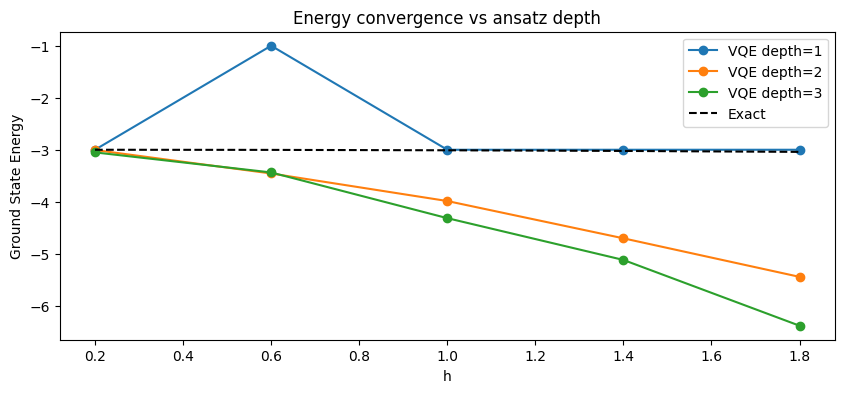

In [32]:
plt.figure(figsize=(10,4))

for layers in depths:
    plt.plot(hs, results[layers]["energy"], 'o-', label=f'VQE depth={layers}')

plt.plot(hs, E0[:len(hs)], 'k--', label='Exact')
plt.xlabel("h")
plt.ylabel("Ground State Energy")
plt.legend()
plt.title("Energy convergence vs ansatz depth")
plt.show()

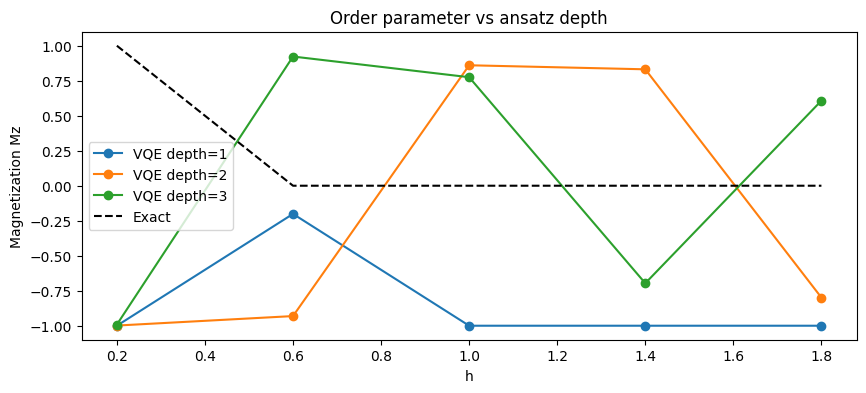

In [33]:
plt.figure(figsize=(10,4))

for layers in depths:
    plt.plot(hs, results[layers]["magnetization"], 'o-', label=f'VQE depth={layers}')

plt.plot(hs, Mz[:len(hs)], 'k--', label='Exact')
plt.xlabel("h")
plt.ylabel("Magnetization Mz")
plt.legend()
plt.title("Order parameter vs ansatz depth")
plt.show()

# Run on Offline and IQM Garnet Hardware

In [34]:
# System
N = 4
J = 1.0

# Fields to probe (keep small for hardware)
hs = [0.2, 0.6, 1.0, 1.4, 1.8]

# VQE / circuit settings
LAYERS = 2          # chosen from depth analysis
MAXITER = 250       # enough for convergence
SHOTS = 8000        # adjust based on IQM quota

np.random.seed(42)

In [35]:
def tfim_hamiltonian(h, N=4):
    paulis, coeffs = [], []

    # ZZ interactions
    for i in range(N - 1):
        term = ['I'] * N
        term[i] = 'Z'
        term[i + 1] = 'Z'
        paulis.append(''.join(term))
        coeffs.append(-J)

    # Transverse field
    for i in range(N):
        term = ['I'] * N
        term[i] = 'X'
        paulis.append(''.join(term))
        coeffs.append(-h)

    return SparsePauliOp(paulis, coeffs)

In [36]:
def tfim_ansatz(N=4, layers=2):
    qc = QuantumCircuit(N)

    for l in range(layers):
        # ZZ entangling layer
        for i in range(N - 1):
            qc.cx(i, i + 1)
            qc.rz(qc.parameters.create(f"θz_{l}_{i}"), i + 1)
            qc.cx(i, i + 1)

        # Transverse-field rotations
        for i in range(N):
            qc.rx(qc.parameters.create(f"θx_{l}_{i}"), i)

    return qc

In [44]:
def optimize_vqe(h):
    H = tfim_hamiltonian(h, N)
    ansatz = tfim_ansatz(N, LAYERS)

    optimizer = COBYLA(maxiter=MAXITER)
    estimator = Estimator()

    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(H)

    optimal_circuit = ansatz.assign_parameters(result.optimal_parameters)

    return result.optimal_parameters, float(np.real(result.eigenvalue)), optimal_circuit

In [45]:
from qiskit.circuit import Parameter

def tfim_ansatz(N=4, layers=2):
    qc = QuantumCircuit(N)

    for l in range(layers):
        # ZZ entangling layer
        for i in range(N - 1):
            theta_z = Parameter(f"θz_{l}_{i}")
            qc.cx(i, i + 1)
            qc.rz(theta_z, i + 1)
            qc.cx(i, i + 1)

        # Transverse-field layer
        for i in range(N):
            theta_x = Parameter(f"θx_{l}_{i}")
            qc.rx(theta_x, i)

    return qc

In [46]:
qc = tfim_ansatz()
print(qc)

                             ┌────────────┐                                 »
q_0: ──■──────────────────■──┤ Rx(θx_0_0) ├─────────────────────────────────»
     ┌─┴─┐┌────────────┐┌─┴─┐└────────────┘                   ┌────────────┐»
q_1: ┤ X ├┤ Rz(θz_0_0) ├┤ X ├──────■───────────────────────■──┤ Rx(θx_0_1) ├»
     └───┘└────────────┘└───┘    ┌─┴─┐     ┌────────────┐┌─┴─┐└────────────┘»
q_2: ────────────────────────────┤ X ├─────┤ Rz(θz_0_1) ├┤ X ├──────■───────»
                                 └───┘     └────────────┘└───┘    ┌─┴─┐     »
q_3: ─────────────────────────────────────────────────────────────┤ X ├─────»
                                                                  └───┘     »
«                                               ┌────────────┐              »
«q_0: ──────■───────────────────────────■───────┤ Rx(θx_1_0) ├──────────────»
«         ┌─┴─┐     ┌────────────┐    ┌─┴─┐     └────────────┘              »
«q_1: ────┤ X ├─────┤ Rz(θz_1_0) ├────┤ X ├───────────■─────────

In [47]:
optimized_params = []
energies_vqe = []
circuits = []

for h in hs:
    params, energy, circuit = optimize_vqe(h)
    optimized_params.append(params)
    energies_vqe.append(energy)
    circuits.append(circuit)

In [48]:
print("Fields:", hs)
print("Number of parameter sets:", len(optimized_params))
print("Number of circuits:", len(circuits))

Fields: [0.2, 0.6, 1.0, 1.4, 1.8]
Number of parameter sets: 5
Number of circuits: 5


In [49]:
from iqm.qiskit_iqm import IQMProvider

provider = IQMProvider(
    "https://resonance.meetiqm.com/",
    quantum_computer="garnet",
    token=input("IQM Resonance token: ")
)

backend = provider.get_backend()
print("Connected to IQM backend:", backend)




ImportError: cannot import name 'convert_to_target' from 'qiskit.providers' (/usr/local/lib/python3.12/dist-packages/qiskit/providers/__init__.py)

In [ ]:
sampler = Sampler(backend=backend)

In [ ]:
print("Submitting ONE batched job to IQM hardware...")

job = sampler.run(circuits, shots=SHOTS)
print("IQM Job ID:", job.job_id())

result = job.result()

In [ ]:
Mz_iqm = []

for res in result:
    counts = res.data.meas.get_counts()
    mz = 0.0

    for bitstring, count in counts.items():
        prob = count / SHOTS
        z_vals = [1 if b == '0' else -1 for b in bitstring]
        mz += prob * sum(z_vals)

    Mz_iqm.append(mz / N)

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(hs, Mz_exact[:len(hs)], 'k--', label="Exact")
plt.plot(hs, Mz_iqm, 's-', label="IQM hardware")

plt.xlabel("h / J")
plt.ylabel("Magnetization $M_z$")
plt.title("TFIM Quantum Phase Transition on IQM Hardware")
plt.legend()
plt.grid(True)
plt.show()